## Limpieza de datos : seleccionando periodos con datos completos



In [171]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os

df = pd.read_csv('data_gdc/gdc_2006_2024_horapunto.csv')
print(df.isnull().sum())
# df.set_index('fhora', inplace=True)
df.info()

fhora                 0
identificacion        0
ddd                   0
dddstd                0
dddx                  0
hr                    0
lluv              43885
pres              38178
temp              51130
ts                53298
vel               33044
velx              33426
qdato                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158052 entries, 0 to 158051
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fhora           158052 non-null  object 
 1   identificacion  158052 non-null  int64  
 2   ddd             158052 non-null  float64
 3   dddstd          158052 non-null  int64  
 4   dddx            158052 non-null  int64  
 5   hr              158052 non-null  int64  
 6   lluv            114167 non-null  float64
 7   pres            119874 non-null  float64
 8   temp            106922 non-null  float64
 9   ts              104754 non-null  float64
 10  vel    

In [176]:
def periodo_not_null(dataframe: pd.DataFrame, target: str, period: int) -> pd.DataFrame:
    """
    Elimina las filas donde haya `period` o más valores nulos consecutivos.
    
    Parámetros:
    - dataframe: Se espera recibir un DataFrame de pandas con la columna que interesa limpiar.
    - target: Nombre de la columna a limpiar.
    - period: Número entero que indica el máximo periodo de valores nulos consecutivos permitidos.
    
    Retorna:
    - DataFrame sin filas donde haya valores nulos consecutivos que excedan el valor de `period`.
    """
    # Crear una serie booleana donde True indica que el valor es nulo
    is_null = dataframe[target].isnull()
    
    # Calcular las rachas (streaks) de valores nulos consecutivos
    streaks = is_null.groupby((is_null != is_null.shift()).cumsum()).cumsum()
    
    # Crear una máscara para identificar rachas que excedan o igualen el periodo
    mask = (streaks >= period) & is_null
    
    # Eliminar las filas donde las rachas de valores nulos excedan el periodo permitido
    dataframe_clean = dataframe.loc[~mask]
    
    return dataframe_clean

def limpieza_dataframe(dataframe: pd.DataFrame, index: str, period: int = 7*24) -> pd.DataFrame:
    """
    Aplica la limpieza de rachas de nulos a cada columna del DataFrame.
    
    Parámetros:
    - dataframe: El DataFrame original.
    - index: Nombre de la columna de índice para asegurar el alineamiento.
    - period: El número máximo de valores nulos consecutivos permitidos.
    
    Retorna:
    - El DataFrame con las columnas limpiadas.
    """
    df_merge = dataframe[[index]].copy() 

    lista_columnas = []

    for col in dataframe.columns:
        if col != index:  
            
            df_col_limpio = periodo_not_null(dataframe[[index, col]], col, period)
            lista_columnas.append(df_col_limpio)
        
            df_merge = pd.concat([df_merge, df_col_limpio[[index, col]]], axis=1, join='inner')

    # Eliminar columnas duplicadas, conservando solo una de cada tipo
    df_merge = df_merge.loc[:, ~df_merge.columns.duplicated()]

    return df_merge


# Aplicar la función de limpieza al DataFrame
df_limpio = limpieza_dataframe(df, 'fhora', period=7*24)

df_limpio.describe()

,identificacion,ddd,dddstd,dddx,hr,lluv,pres,temp,ts,vel,velx,qdato
count,92437.0,92437.000000,92437.000000,92437.000000,92437.000000,87483.000000,87269.000000,87142.000000,87481.000000,87252.000000,87091.000000,92437.0
mean,89070.0,3.234033,9.596785,141.727782,81.181561,0.009021,988.582320,-0.632921,-0.081578,6.746101,9.893933,0.0
std,0.0,1.884657,16.640351,123.122112,21.707971,0.051559,11.956705,3.614448,3.172697,3.976665,5.785158,0.0
min,89070.0,0.000000,0.000000,0.000000,0.000000,0.000000,938.500000,-22.300000,-17.600000,0.000000,0.000000,0.0
25%,89070.0,1.378810,0.000000,0.000000,78.000000,0.000000,980.700000,-2.300000,-1.700000,3.700000,5.300000,0.0
50%,89070.0,3.822271,8.000000,126.000000,88.000000,0.000000,988.600000,0.100000,0.300000,6.300000,9.100000,0.0
75%,89070.0,4.712389,13.000000,250.000000,93.000000,0.000000,996.900000,1.800000,2.000000,9.400000,13.700000,0.0
max,89070.0,6.283185,354.000000,359.000000,100.000000,4.200000,1024.900000,12.500000,13.700000,27.600000,37.700000,0.0


In [177]:
# Calcular los resultados para df
result_df = pd.DataFrame()
result_df['SumNulls'] = df.isnull().sum()
result_df['PerNull'] = (df.isnull().sum() / len(df) * 100).round(2) 
result_df['TotalAccount'] = df.count()
result_df['DataFrame'] = 'df'  # Añadir una columna para identificar el DataFrame
result_df['Column'] = df.columns  # Añadir una columna para las columnas del DataFrame original

# Calcular los resultados para df_limpio
result_df_limpio = pd.DataFrame()
result_df_limpio['SumNulls'] = df_limpio.isnull().sum()
result_df_limpio['PerNull'] = (df_limpio.isnull().sum() / len(df) * 100).round(2)
result_df_limpio['TotalAccount'] = df_limpio.count()
result_df_limpio['DataFrame'] = 'df_limpio'  # Añadir una columna para identificar el DataFrame
result_df_limpio['Column'] = df_limpio.columns  # Añadir una columna para las columnas del DataFrame original

# Combinar los resultados en un solo DataFrame
result = pd.concat([result_df, result_df_limpio])

# Crear una tabla pivotante
pivot_table = result.pivot_table(index=['DataFrame', 'Column'], values=['SumNulls', 'PerNull', 'TotalAccount'])
print(pivot_table)

                          PerNull  SumNulls  TotalAccount
DataFrame Column                                         
df        ddd                0.00       0.0      158052.0
          dddstd             0.00       0.0      158052.0
          dddx               0.00       0.0      158052.0
          fhora              0.00       0.0      158052.0
          hr                 0.00       0.0      158052.0
          identificacion     0.00       0.0      158052.0
          lluv              27.77   43885.0      114167.0
          pres              24.16   38178.0      119874.0
          qdato              0.00       0.0      158052.0
          temp              32.35   51130.0      106922.0
          ts                33.72   53298.0      104754.0
          vel               20.91   33044.0      125008.0
          velx              21.15   33426.0      124626.0
df_limpio ddd                0.00       0.0       92437.0
          dddstd             0.00       0.0       92437.0
          dddx

In [184]:
df_limpio.to_csv('gdc_limpieza_nulos.csv')

### Método manual pero aplicado columna a columna

In [68]:
df_seleccionado = df[['fhora','temp']]
target = 'temp'
period = 7*24

df_sin_nulos = periodo_not_null(df_seleccionado, target, period)

df.isnull().sum()

print('Dataframe original: ', df[target].isnull().sum(), '\n', f'Dataframe para la col {target} sin nulos: ', df_sin_nulos[target].isnull().sum())

print( f'Recuento de valores totales: \n', df_sin_nulos.count())

Dataframe original:  51130 
 Dataframe para la col temp sin nulos:  5936
Recuento de valores totales: 
 fhora    112858
temp     106922
dtype: int64


In [39]:
df_seleccionado = df_seleccionado.set_index('fhora')
df_sin_nulos = df_sin_nulos.set_index('fhora')

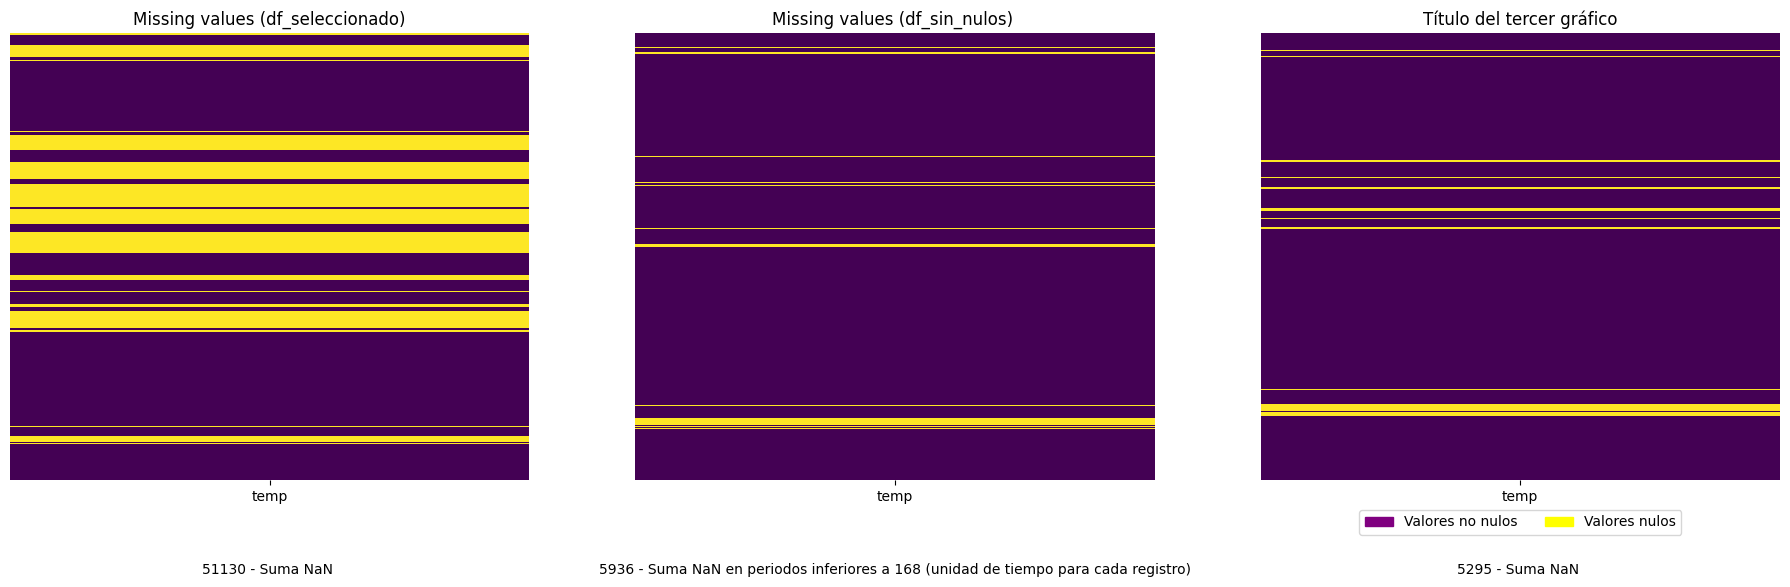

In [182]:
import matplotlib.patches as mpatches
# Crear una figura con tres subplots (1 fila, 3 columnas)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Primer gráfico: df_seleccionado
sns.heatmap(df_seleccionado[['temp']].isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[0])
axes[0].set_title(f'Missing values (df_seleccionado)')
axes[0].text(0.5, -0.2, f'{df_seleccionado["temp"].isnull().sum()} - Suma NaN ', 
             ha='center', va='center', transform=axes[0].transAxes)

# Segundo gráfico: df_sin_nulos
sns.heatmap(df_sin_nulos[['temp']].isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[1])
axes[1].set_title(f'Missing values (df_sin_nulos) ')
axes[1].text(0.5, -0.2, f'{df_sin_nulos["temp"].isnull().sum()} - Suma NaN en periodos inferiores a {period} (unidad de tiempo para cada registro)', 
             ha='center', va='center', transform=axes[1].transAxes)

#Tercer gráfico: Añade aquí el código para el tercer gráfico
sns.heatmap(df_limpio[['temp']].isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[2])
axes[2].set_title('Título del tercer gráfico')
axes[2].text(0.5, -0.2, f'{df_limpio["temp"].isnull().sum()} - Suma NaN ', 
             ha='center', va='center', transform=axes[2].transAxes)

# Añadir la leyenda
null_patch = mpatches.Patch(color='purple', label='Valores no nulos')  # Ajustar el color según el mapa de colores usado
non_null_patch = mpatches.Patch(color='yellow', label='Valores nulos')  # Ajustar el color según el mapa de colores usado
plt.legend(handles=[null_patch, non_null_patch], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Ajustar el espacio entre los gráficos para que no se solapen
plt.tight_layout()

# Mostrar la figura
plt.show()

ValueError: Grouper for '<class 'pandas.core.frame.DataFrame'>' not 1-dimensional